# Task: saliency map via occlusion

In this task, you have a trained classifier and want to identify which parts of an image most influenced its prediction for a specific class. A simple method for this is to occlude portions of the image and observe the decrease in the predicted class probability compared to the original image's probability.

Create a heatmap of those occlusions:
* Take the original image (168×224) and replace a square of size 20×20 centered at point (i,j) (and cropped to the image frame) with a value of your choice.
* Pass the image through the network and calculate the drop in the probability of class `GOLDFISH_LABEL`.
* Do this with overlapping squares, with centers that cover the whole image, on a grid with stride 10: ((0,0), (0,10), ..., (10,0), (10,10), ..., (170,230)).
* Return the heatmap as a 2D np.array (of shape (18, 24)).

This should run under 2 minutes on CPU.

## Definitions

In [1]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn
from PIL import Image
from torch import Tensor
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from typing import cast

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


GOLDFISH_LABEL = MobileNet_V2_Weights.DEFAULT.meta["categories"].index("goldfish")


def get_image(
    url: str = "http://www.mimuw.edu.pl/~cygan/welonka.jpg",
    target_max_size: int = 224
) -> Tensor:
    """Return image as tensor of shape (C=3, H, W), normalized values."""
    img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    transformations = v2.Compose([
        v2.Resize(size=None, max_size=target_max_size),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),  # scale to 0..1
        v2.Normalize(
            mean=IMAGENET_DEFAULT_MEAN,
            std=IMAGENET_DEFAULT_STD
        ),
    ])
    return cast(Tensor, transformations(img))


def tensor_to_pil(image: Tensor) -> PIL.Image.Image:
    """Convert normalized image tensor of shape (C, H, W) to PIL Image."""
    C, H, W = image.shape
    image = image.detach().permute(1, 2, 0).clone()  # to (H, W, C)
    image *= torch.tensor(IMAGENET_DEFAULT_STD)
    image += torch.tensor(IMAGENET_DEFAULT_MEAN)
    img = PIL.Image.fromarray((image.numpy() * 255).astype(np.uint8))
    return img


DEFAULT_DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model(training: bool = False, device: str = DEFAULT_DEVICE) -> torch.nn.Module:
    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.to(torch.device(device))
    model.train(training)
    return model


def plot_heatmap(heatmap: np.ndarray) -> None:
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()


def plot_heatmap_over_image(image: Tensor, heatmap: np.ndarray, stride: int = 10, zoom: float = 2.0) -> None:
    """Show heatmap over image."""
    C, H, W = image.shape
    rows, cols = heatmap.shape

    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap = plt.get_cmap("viridis")(heatmap)
    heatmap_image = PIL.Image.fromarray((heatmap * 255).astype(np.uint8))
    heatmap_image = heatmap_image.resize((cols * stride, rows * stride), resample=PIL.Image.NEAREST)
    heatmap_image = heatmap_image.crop((stride // 2, stride // 2, W + stride // 2, H + stride // 2))
    result = PIL.Image.blend(tensor_to_pil(image).convert("RGBA"), heatmap_image, alpha=0.8)
    result = result.resize((int(W * zoom), int(H * zoom)))
    display(result)

## Your code

In [2]:
def generate_heatmap(model: torch.nn.Module, image: Tensor, stride: int = 10, window: int = 20) -> np.ndarray:
    HEIGHT, WIDTH = image.size()[1], image.size()[2]
    def occlude_position(org_image: Tensor, window: int, pos: list[int], value: tuple[int]) -> Tensor:
        I, J = pos
        image = org_image.clone()
        start_i = max(I - window//2, 0)
        start_j = max(J - window//2, 0)
        end_i = min(I + window//2, HEIGHT)
        end_j = min(J + window//2, WIDTH)

        for i in range(start_i, end_i):
            for j in range(start_j, end_j):
                image[(0, i, j)], image[(1, i, j)], image[(2, i, j)] = value
        return image

    def run_model(image: Tensor, model: torch.nn.Module) -> float:
        model.eval()
        with torch.no_grad():
            logits = model(image.unsqueeze(0))
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs[0, GOLDFISH_LABEL].item()


    grid = np.array([[(i, j) for j in range(0, WIDTH+stride, stride)] for i in range(0, HEIGHT+stride, stride)])
    original_prob = run_model(image, model)
    heatmap = np.zeros((grid.shape[0], grid.shape[1]))

    print(original_prob)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            heatmap[i, j] = original_prob - run_model(occlude_position(image, window, grid[i, j], (0, 0, 0)), model)
    # for (i, j) in grid

    return heatmap

## Test

0.7647846937179565
Shape (35, 46)


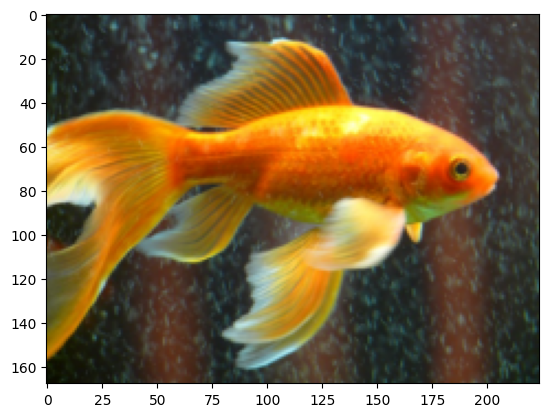

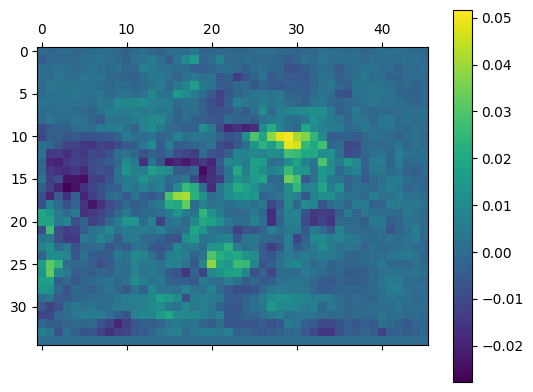

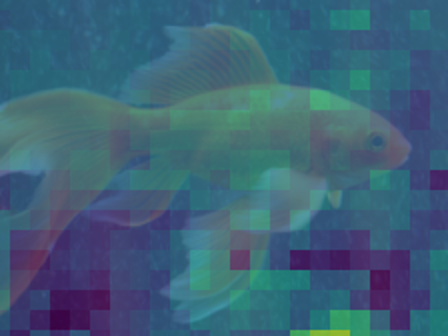

In [4]:
image = get_image()
model = get_model()
heatmap = generate_heatmap(model, image, stride=5, window=5)

print("Shape", heatmap.shape)
plt.imshow(tensor_to_pil(image))
plot_heatmap(heatmap)
plot_heatmap_over_image(image, heatmap)